# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Нам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.

Необходимо построить модель с предельно большим значением *F1*-меры (довести метрику до 0.59).

Дополнительно будем измерять *ROC-AUC* и сравнивать её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

Загрузим нужные для работы библиотеки и загрузим и сохраним данные в переменную df

In [101]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score, \
                            f1_score, r2_score, confusion_matrix, roc_curve, auc

RANDOM_STATE_ = 12345

import warnings
warnings.filterwarnings("ignore")

In [102]:
try:
    df = pd.read_csv('/datasets/Churn.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/Churn.csv')

In [103]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Посмотрим на пропуски и на количество уникальных значений:

In [105]:
df.isna().sum()

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

In [106]:
df.nunique()

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

**Опишем признаки:**

RowNumber — индекс строки в данных <br>
CustomerId — уникальный идентификатор клиента <br>
Surname — фамилия <br>
CreditScore — числовой признак: кредитный рейтинг <br>
Geography — категориальный признак: страна проживания <br>
Gender — категориальный признак: пол <br>
Age — числовой признак: возраст <br>
Tenure — числовой признак: сколько лет человек является клиентом банка <br>
Balance — числовой признак: баланс на счёте <br>
NumOfProducts — числовой признак: количество продуктов банка, используемых клиентом <br>
HasCrCard — числовой признак: наличие кредитной карты <br>
IsActiveMember — числовой признак: активность клиента <br>
EstimatedSalary — числовой признак: предполагаемая зарплата <br>

Каждый объект в наборе данных - это данные одного клиента

In [107]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


**Выводы:**

- Датафрейм в 10000 записей и 14 признаков
- Имена столбцов нужно привести к "змеиному" стилю
- Признаки RowNumber, CustomerId - искусственно созданные уникальные значения, их наличие не несет смысловой нагрузки для исследования и будет мешать обучению модели - от них избавимся перед построением модели. Аналогично с признаком Surname
- Перед обучением модели признаки требуют масштабирования (CreditScore, Age, Balance, EstimatedSalary)
- Категориальный признак Geography (три страны - Франция, Испания, Германия) и бинарный категориальный признак Gender подлежат перекодированию в числовой
- Признак Tenure - числовой, он показывает сколько лет человек является клиентом банка (от 0 до 10 лет). Тип данных float и пропущено в районе 10% данных. Поменяем тип данных на int и попытаемся заполнить пропущенные данные.
- HasCrCard, IsActiveMember - числовые бинарные признаки
- Корреляции признаков не наблюдается
- Exited - целевой бинарный признак

## Предобработка данных



Приведем названия столбцов к "змеиному" стандарту

In [108]:
df.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', i).lower() for i in df.columns]

In [109]:
df.columns

Index(['row_number', 'customer_id', 'surname', 'credit_score', 'geography',
       'gender', 'age', 'tenure', 'balance', 'num_of_products', 'has_cr_card',
       'is_active_member', 'estimated_salary', 'exited'],
      dtype='object')

Удалим бесполезные для модели признаки

In [110]:
df.drop(columns = ['row_number','customer_id','surname'], inplace = True)

Обработаем данные от пропусков в параметре Tenure.
Исключать этот признак будет не лучшим решением, с точки зрения логики он важен для исследования.
Среди вариантов избавления от пропусков возможно заполнение пропусков медианным значением, однако выберу вариант удаления строк с пропусками, предварительно ознакомившись со статистиками данных, от которых мы вынуждены избавиться

In [111]:
len(df[df['tenure'].isna()]) / len(df)

0.0909

In [112]:
df[df['tenure'].isna()].describe()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
count,909.000000,909.000000,0.0,909.000000,909.000000,909.000000,909.000000,909.000000,909.000000
mean,648.451045,38.647965,NaN,76117.341474,1.530253,0.710671,0.510451,99180.389373,0.201320
std,99.079381,9.785438,NaN,63105.690715,0.588452,0.453701,0.500166,56378.063765,0.401207
min,359.000000,18.000000,NaN,0.000000,1.000000,0.000000,0.000000,106.670000,0.000000
25%,580.000000,32.000000,NaN,0.000000,1.000000,0.000000,0.000000,49872.330000,0.000000
50%,647.000000,37.000000,NaN,96674.550000,1.000000,1.000000,1.000000,99444.020000,0.000000
75%,718.000000,43.000000,NaN,128554.980000,2.000000,1.000000,1.000000,145759.700000,0.000000
max,850.000000,92.000000,NaN,206663.750000,4.000000,1.000000,1.000000,199390.450000,1.000000


In [113]:
df = df.dropna()

Далее проверим признаки на корреляции:

In [114]:
df.corr()

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
credit_score,1.000000,-0.004504,-0.000062,0.002804,0.011090,-0.003937,0.030947,0.005182,-0.023950
age,-0.004504,1.000000,-0.013134,0.031481,-0.031877,-0.014129,0.082269,-0.007037,0.283017
tenure,-0.000062,-0.013134,1.000000,-0.007911,0.011979,0.027232,-0.032178,0.010520,-0.016761
balance,0.002804,0.031481,-0.007911,1.000000,-0.301858,-0.019055,-0.003285,0.014351,0.117218
num_of_products,0.011090,-0.031877,0.011979,-0.301858,1.000000,0.005805,0.009084,0.013990,-0.050271
has_cr_card,-0.003937,-0.014129,0.027232,-0.019055,0.005805,1.000000,-0.008810,-0.006136,-0.005411
is_active_member,0.030947,0.082269,-0.032178,-0.003285,0.009084,-0.008810,1.000000,-0.020049,-0.155062
estimated_salary,0.005182,-0.007037,0.010520,0.014351,0.013990,-0.006136,-0.020049,1.000000,0.016029
exited,-0.023950,0.283017,-0.016761,0.117218,-0.050271,-0.005411,-0.155062,0.016029,1.000000


<Axes: >

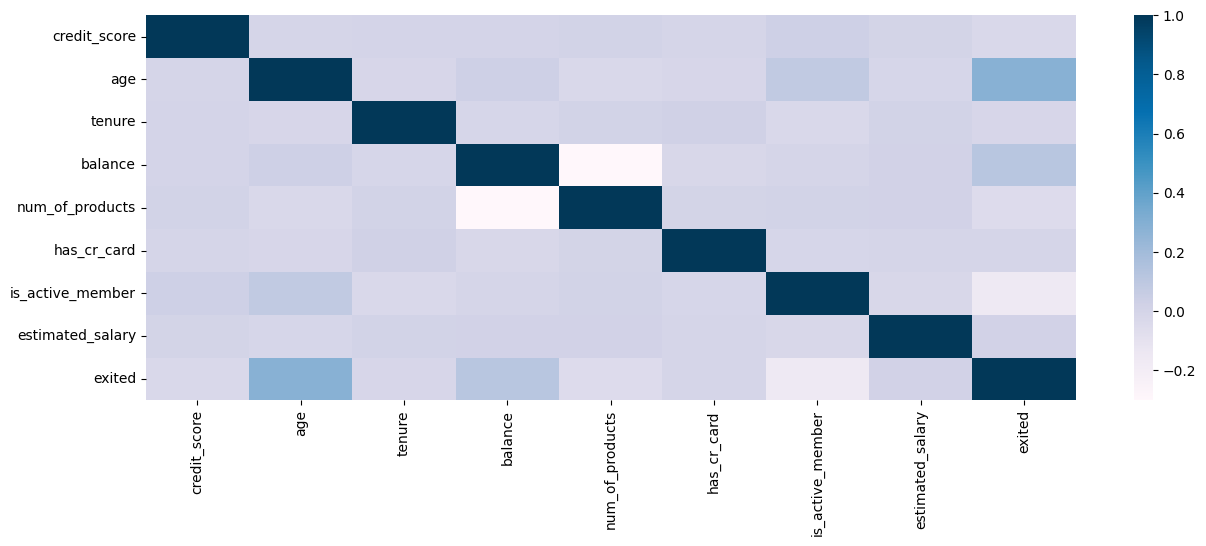

In [115]:
plt.figure(figsize=(15,5))
sns.heatmap(df.corr(), cmap='PuBu')

Наибольшая корреляция у баланса и количества используемых продуктов (~30%). Корреляцию нельзя назвать сильной, оставляем все признаки для анализа

Посмотрим на распределение клиентов по странам и полу:

In [116]:
df['geography'].value_counts()

France     4550
Germany    2293
Spain      2248
Name: geography, dtype: int64

In [117]:
df['gender'].value_counts()

Male      4974
Female    4117
Name: gender, dtype: int64

Разделим датасет на 3 части в соотношении 3:1:1 (60% обучающая выборка, 20% валидационная и 20% тестовая)

In [118]:
# создадим признаки
features = df.drop(['exited'] , axis=1)
target = df['exited']

# создадим обучающую выборку и валидационную выборки
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.40, random_state=RANDOM_STATE_, stratify=target)

# разделим валидационную пополам - получим тестовую выборку
features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, test_size=0.50, random_state=RANDOM_STATE_, stratify=target_valid)

print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

print(len(features_train) / len(df))
print(len(features_valid) / len(df))
print(len(features_test) / len(df))

(5454, 10)
(1818, 10)
(1819, 10)
0.5999340006599934
0.1999780002199978
0.2000879991200088


У числовых признаков в наборе данных разные диапазоны, что может привести к ситуации, когда один из признаков окажется более важен не по объективным причинам, а за счет масштаба. Приведем признаки к единому масштабу.

Далее перекодируем категориальные признаки Geography и Gender в числовые с помощью One-Hot Encoding.

Также у числовых признаков в наборе данных разные диапазоны, что может привести к ситуации, когда один из признаков окажется более важен не по объективным причинам, а за счет масштаба. Приведем признаки к единому масштабу.

In [119]:
#создадим список категориальных признаков:
categorial_features = features_train.select_dtypes(include='object').columns.to_list()
print('Cписок категориальных признаков:', categorial_features)

#создадим список числовых признаков и удалим из него бинарные признаки:
num_features = features_train.select_dtypes(exclude='object').columns.to_list()
num_features.remove('has_cr_card')
num_features.remove('is_active_member')
print('Cписок числовых признаков:', num_features)

Cписок категориальных признаков: ['geography', 'gender']
Cписок числовых признаков: ['credit_score', 'age', 'tenure', 'balance', 'num_of_products', 'estimated_salary']


In [120]:
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='error', sparse=False)

encoder_ohe.fit(features_train[categorial_features])

features_train[
    encoder_ohe.get_feature_names_out()
] = encoder_ohe.transform(features_train[categorial_features])

features_train = features_train.drop(categorial_features, axis=1)


scaler = StandardScaler()

features_train[num_features] = scaler.fit_transform(features_train[num_features])

print('Размер выборки:', features_train.shape)
display(features_train.head())

Размер выборки: (5454, 11)


,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
9723,-1.292898,-0.660843,0.686341,0.786636,-0.910943,0,0,-0.223548,0.0,0.0,1.0
1224,-1.563714,0.778434,1.034232,0.833795,-0.910943,1,0,1.383021,0.0,1.0,0.0
8377,1.581914,0.106771,-0.357331,-1.222967,0.789359,1,1,-0.308331,0.0,1.0,1.0
8014,0.842379,0.010820,-1.053112,0.807063,-0.910943,1,1,-0.430980,0.0,1.0,0.0
2491,-0.397123,-1.236554,-0.357331,-1.222967,0.789359,1,1,1.392642,0.0,1.0,0.0


Теперь трансформируем валидационную и тестовую выборки

In [121]:
features_valid[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(
     features_valid[categorial_features]
)
features_test[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(
     features_test[categorial_features]
)

features_valid = features_valid.drop(categorial_features, axis=1)
features_test = features_test.drop(categorial_features, axis=1)

features_valid[num_features] = scaler.transform(features_valid[num_features])
features_test[num_features] = scaler.transform(features_test[num_features])

print('Валидационная выборка:', features_valid.shape)
display(features_valid.head())
print('Тестовая выборка:', features_test.shape)
display(features_test.head())

Валидационная выборка: (1818, 11)


,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
7493,-0.417955,-0.181084,1.730013,1.023931,0.789359,1,1,0.519901,0.0,1.0,0.0
5460,0.113260,0.202723,-0.009440,0.738812,0.789359,0,1,0.364920,1.0,0.0,1.0
9126,1.071531,1.162241,-0.357331,0.054632,0.789359,0,1,-0.545522,0.0,1.0,1.0
9801,-0.845011,-0.852747,-0.705222,1.010554,-0.910943,1,1,-1.154323,0.0,1.0,0.0
9101,-0.553363,-0.085132,0.338450,0.629162,0.789359,1,1,-1.296336,0.0,1.0,1.0


Тестовая выборка: (1819, 11)


,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
4126,0.259084,-0.660843,1.730013,-1.222967,0.789359,1,0,1.597110,0.0,1.0,1.0
5145,1.394426,-0.085132,-1.401003,0.994334,-0.910943,1,1,1.253399,1.0,0.0,1.0
9253,-0.063812,0.970338,1.730013,-1.222967,0.789359,1,1,0.789730,0.0,1.0,1.0
6757,0.696555,-0.277036,-1.053112,0.425659,0.789359,0,1,-0.877030,0.0,1.0,1.0
9739,0.279916,-1.332505,-0.705222,-1.222967,0.789359,1,0,1.389657,0.0,0.0,0.0


Изменим тип данных Tenure на целочисленный

In [122]:
df['tenure'] = df['tenure'].astype(int)

In [123]:
df.head()

,credit_score,geography,gender,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Посмотрим на соотношение клиентов по целевому признаку - расторжению банковского договора

In [124]:
df['exited'].value_counts()

0    7237
1    1854
Name: exited, dtype: int64

In [125]:
print('Процент ушедших клиентов:', round(len(df[df['exited'] == 1]) / len(df) * 100, 2), '%')

Процент ушедших клиентов: 20.39 %


0    0.796062
1    0.203938
Name: exited, dtype: float64

Text(0, 0.5, 'Количество записей')

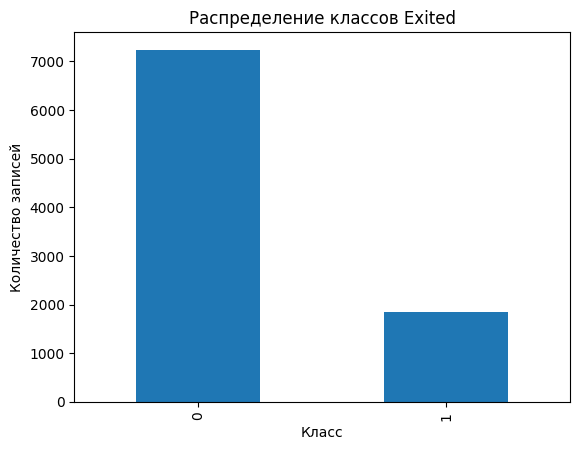

In [126]:
display(df['exited'].value_counts(normalize=1))
df['exited'].value_counts().plot(kind='bar')
plt.title('Распределение классов Exited')
plt.xlabel('Класс')
plt.ylabel('Количество записей')

Мы видим, что за анализируемый период ~20% клиентов расторгли договор обслуживания.

Можно сделать вывод, что существует дисбаланс классов с соотношением примерно равным 80/20 (0/1)

**Выводы по первому этапу:**

- Загрузили датафрейм и исследовали его
- Удалили нецелевые для исследования признаки (row_number, customer_id и surname)
- Избавились от пропусков в параметре Tenure
- С помощью ОНЕ перекодировали признаки geography и gender в числовые
- Масштабировали числовые признаки credit_score, age, balance, estimated_salary
- Обнаружили в  целевом признаке exited достаточно сильный дисбаланс классов - только 20% отражают факт ухода клиента

## Построение моделей

Вначале исследуем данные без учета дисбаланса классов с помощью моделей:

DecisionTreeClassifier (Дерево решений) <br>
RandomForestClassifier (Случайный лес) <br>
LogisticRegression (Логистическая регрессия) <br>

### DecisionTreeClassifier (Дерево решений)

Подберем оптимальные гиперпараметры для дерева решений:

In [127]:
%%time

best_model = None
best_model_depth = 0
best_model_leaf = 0
best_result = 0

for depth in range(1, 20):
    for i in range(1, 50):
            model = DecisionTreeClassifier(random_state=RANDOM_STATE_, max_depth=depth, min_samples_leaf=i)
            model.fit(features_train, target_train)
            predictions = model.predict(features_valid)
            result = f1_score(target_valid, predictions)
            if result > best_result:
                best_model_dtc = model
                best_model_depth = depth
                best_model_leaf = i
                best_result = result
print('Лучший результат F1 score:', best_result)
print('Гиперпараметры:', 'max_depth:', best_model_depth, ', min_samples_leaf:', best_model_leaf)

Лучший результат F1 score: 0.5939597315436241
Гиперпараметры: max_depth: 7 , min_samples_leaf: 3
CPU times: user 23.1 s, sys: 54.8 ms, total: 23.2 s
Wall time: 23.4 s


Обучим модель с подобранными гиперпараметрами и посмотрим метрики:

In [128]:
predictions = best_model_dtc.predict(features_valid)

accuracy_valid_dtc = accuracy_score(predictions, target_valid)
precision_valid_dtc = precision_score(target_valid, predictions)
recall_valid_dtc = recall_score(target_valid, predictions)
f1_score_dtc = f1_score(target_valid, predictions)

print('Accuracy score:', accuracy_valid_dtc)
print('Precision score:', precision_valid_dtc)
print('Recall score:', recall_valid_dtc)
print('F1 score:', f1_score_dtc)

Accuracy score: 0.8668866886688669
Precision score: 0.7866666666666666
Recall score: 0.477088948787062
F1 score: 0.5939597315436241


In [129]:
probabilities_valid = best_model_dtc.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
roc_auc_dtc = roc_auc_score(target_valid, probabilities_one_valid)
print('ROC-AUC дерева решений:', roc_auc_dtc)

ROC-AUC дерева решений: 0.8391457742294216


Визуализируем матрицу ошибок

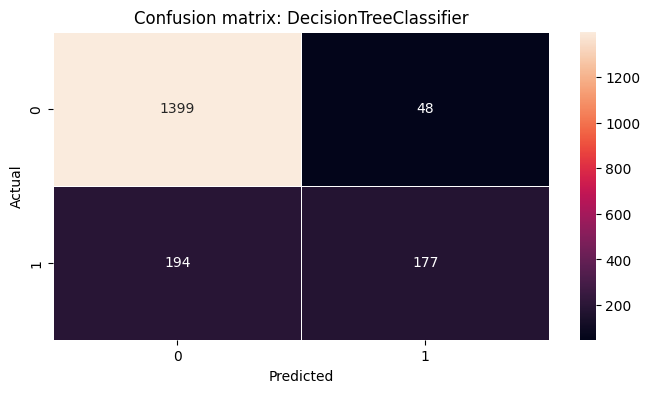

In [130]:
plt.figure(figsize=(8, 4))
sns.heatmap(confusion_matrix(target_valid, predictions), annot=True, fmt='g', linewidth=.5)
plt.title('Confusion matrix: DecisionTreeClassifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### RandomForestClassifier (Случайный лес)

Подберем оптимальные гиперпараметры для случайного леса:

In [131]:
%%time

best_model = None
best_model_est = 0
best_model_depth = 0
best_result = 0
for est in range(10, 101, 10):
    for depth in range(1, 20):
        model = RandomForestClassifier(random_state=RANDOM_STATE_, n_estimators=est, max_depth=depth)
        model.fit(features_train, target_train)
        predictions = model.predict(features_valid)
        result = f1_score(target_valid, predictions)
        if result > best_result:
            best_model_rfc = model
            best_result = result
            best_model_est = est
            best_model_depth = depth
print('Лучший результат F1 score:', best_result)
print('Гиперпараметры:', 'n_estimators:', best_model_est, ', max_depth:', best_model_depth)

Лучший результат F1 score: 0.6219312602291325
Гиперпараметры: n_estimators: 90 , max_depth: 19
CPU times: user 1min 16s, sys: 224 ms, total: 1min 16s
Wall time: 1min 17s


Обучим модель с подобранными гиперпараметрами и посмотрим метрики:

In [132]:
predictions = best_model_rfc.predict(features_valid)

accuracy_valid_rfc = accuracy_score(predictions, target_valid)
precision_valid_rfc = precision_score(target_valid, predictions)
recall_valid_rfc = recall_score(target_valid, predictions)
f1_score_rfc = f1_score(target_valid, predictions)

print('Accuracy score:', accuracy_valid_rfc)
print('Precision score:', precision_valid_rfc)
print('Recall score:', recall_valid_rfc)
print('F1 score:', f1_score_rfc)

Accuracy score: 0.8729372937293729
Precision score: 0.7916666666666666
Recall score: 0.5121293800539084
F1 score: 0.6219312602291325


In [133]:
probabilities_valid = best_model_rfc.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
roc_auc_rfc = roc_auc_score(target_valid, probabilities_one_valid)
print('ROC-AUC случайного леса:', roc_auc_rfc)

ROC-AUC случайного леса: 0.8709133312346207


Визуализируем матрицу ошибок

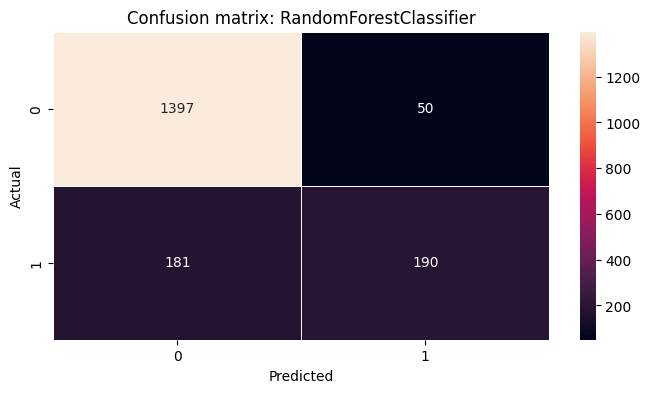

In [134]:
plt.figure(figsize=(8, 4))
sns.heatmap(confusion_matrix(target_valid, predictions), annot=True, fmt='g', linewidth=.5)
plt.title('Confusion matrix: RandomForestClassifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### LogisticRegression (Логистическая регрессия)

Подберем оптимальные гиперпараметры для логистической регрессии:

In [135]:
%%time

best_model = None
best_model_iter = 0
best_result = 0
for iter in range(100, 10000, 100):
    model = LogisticRegression(random_state=RANDOM_STATE_, solver='lbfgs', max_iter=iter)
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    result = f1_score(target_valid, predictions)
    if result > best_result:
        best_model_lr = model
        best_result = result
        best_model_iter = iter
print('Лучший результат F1 score:', best_result)
print('Гиперпараметры:', 'n_estimators:', best_model_iter)

Лучший результат F1 score: 0.3306772908366534
Гиперпараметры: n_estimators: 100
CPU times: user 2.95 s, sys: 2.03 s, total: 4.99 s
Wall time: 3.8 s


Обучим модель с подобранными гиперпараметрами и посмотрим метрики:

In [136]:
predictions = best_model_lr.predict(features_valid)

accuracy_valid_lr = accuracy_score(predictions, target_valid)
precision_valid_lr = precision_score(target_valid, predictions)
recall_valid_lr = recall_score(target_valid, predictions)
f1_score_lr = f1_score(target_valid, predictions)

print('Accuracy score:', accuracy_valid_lr)
print('Precision score:', precision_valid_lr)
print('Recall score:', recall_valid_lr)
print('F1 score:', f1_score_lr)

Accuracy score: 0.8151815181518152
Precision score: 0.6335877862595419
Recall score: 0.22371967654986524
F1 score: 0.3306772908366534


In [137]:
probabilities_valid = best_model_lr.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
roc_auc_lr = roc_auc_score(target_valid, probabilities_one_valid)
print('ROC-AUC логистической регрессии:', roc_auc_lr)

ROC-AUC логистической регрессии: 0.7893382907660986


Визуализируем матрицу ошибок

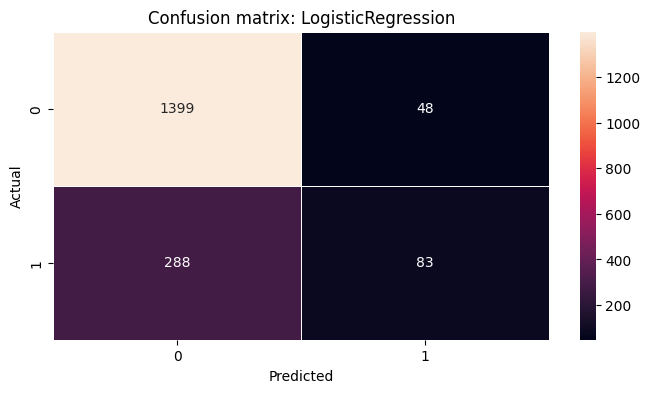

In [138]:
plt.figure(figsize=(8, 4))
sns.heatmap(confusion_matrix(target_valid, predictions), annot=True, fmt='g', linewidth=.5)
plt.title('Confusion matrix: LogisticRegression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Соберем данные исследования в таблицу:

In [139]:
data = [{'Accuracy': accuracy_valid_dtc, 'Recall': recall_valid_dtc, 'Precision': precision_valid_dtc, 'F1': f1_score_dtc, 'ROC-AUC': roc_auc_dtc},
                  {'Accuracy': accuracy_valid_rfc, 'Recall': recall_valid_rfc, 'Precision': precision_valid_rfc, 'F1': f1_score_rfc, 'ROC-AUC': roc_auc_rfc},
                  {'Accuracy': accuracy_valid_lr, 'Recall': recall_valid_lr, 'Precision': precision_valid_lr, 'F1': f1_score_lr, 'ROC-AUC': roc_auc_lr}]
model_result = pd.DataFrame(data, index=['DecisionTreeClassifier (Дерево решений)',
                                             'RandomForestClassifier (Случайный лес)',
                                             'LogisticRegression (Логистическая регрессия)'])
model_result

,Accuracy,Recall,Precision,F1,ROC-AUC
DecisionTreeClassifier (Дерево решений),0.866887,0.477089,0.786667,0.593960,0.839146
RandomForestClassifier (Случайный лес),0.872937,0.512129,0.791667,0.621931,0.870913
LogisticRegression (Логистическая регрессия),0.815182,0.223720,0.633588,0.330677,0.789338


**Выводы:**

При исследовании моделей без учета дисбаланса классов мы наблюдаем, что по метрике F1-Score лучший результат показывает модель RandomForestClassifier (Случайный лес).

Матрицы ошибок указывают на сильный дисбаланс классов - совпадение факта с предсказанием, что клиент не ушел определяются в разы чаще, чем факт ухода клиента

## Борьба с дисбалансом

Для борьбы с дисбалансом классов рассмотрим следующие методы:


Взвешивание классов

Увеличение выборки (upsampling)

Уменьшение выборки (downsampling) при помощи RandomUnderSampler

### Взвешивание классов

Придадим объектам редкого класса больший вес

#### DecisionTreeClassifier (Дерево решений)

In [140]:
%%time

best_model = None
best_model_depth = 0
best_model_leaf = 0
best_result = 0

for depth in range(1, 20):
    for i in range(1, 50):
            model = DecisionTreeClassifier(random_state=RANDOM_STATE_, max_depth=depth, min_samples_leaf=i,
                                           class_weight='balanced')
            model.fit(features_train, target_train)
            predictions = model.predict(features_valid)
            result = f1_score(target_valid, predictions)
            if result > best_result:
                best_model_dtc_wc = model
                best_model_depth = depth
                best_model_leaf = i
                best_result = result
print('Лучший результат F1 score:', best_result)
print('Гиперпараметры:', 'max_depth:', best_model_depth, ', min_samples_leaf:', best_model_leaf)

Лучший результат F1 score: 0.5993623804463338
Гиперпараметры: max_depth: 8 , min_samples_leaf: 43
CPU times: user 25.1 s, sys: 41.7 ms, total: 25.1 s
Wall time: 25.3 s


Обучим модель с подобранными гиперпараметрами

In [141]:
predictions = best_model_dtc_wc.predict(features_valid)

accuracy_valid_dtc = accuracy_score(predictions, target_valid)
precision_valid_dtc = precision_score(target_valid, predictions)
recall_valid_dtc = recall_score(target_valid, predictions)
f1_score_dtc = f1_score(target_valid, predictions)

print('Accuracy score:', accuracy_valid_dtc)
print('Precision score:', precision_valid_dtc)
print('Recall score:', recall_valid_dtc)
print('F1 score:', f1_score_dtc)

Accuracy score: 0.7926292629262927
Precision score: 0.49473684210526314
Recall score: 0.7601078167115903
F1 score: 0.5993623804463338


In [142]:
probabilities_valid = best_model_dtc_wc.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
roc_auc_dtc = roc_auc_score(target_valid, probabilities_one_valid)
print('ROC-AUC дерева решений:', roc_auc_dtc)

ROC-AUC дерева решений: 0.8557793147640718


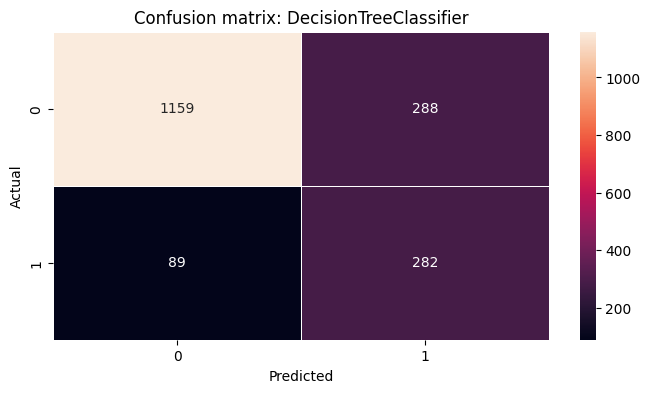

In [143]:
plt.figure(figsize=(8, 4))
sns.heatmap(confusion_matrix(target_valid, predictions), annot=True, fmt='g', linewidth=.5)
plt.title('Confusion matrix: DecisionTreeClassifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

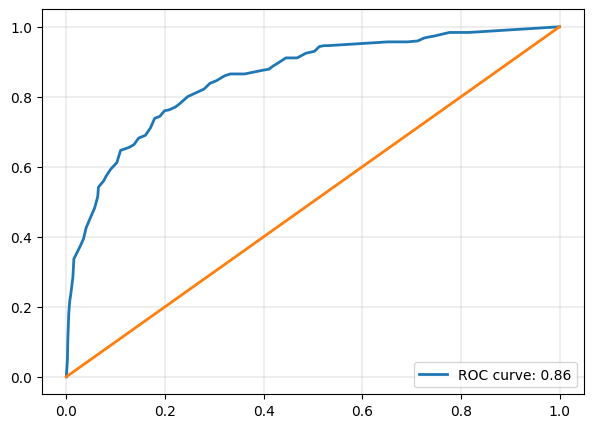

In [144]:
plt.figure(figsize=(7, 5))
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, label=f'ROC curve: {roc_auc_dtc:.2f}')
plt.plot([0, 1], [0, 1], lw=2, linestyle='-')
plt.legend(loc='lower right')
plt.grid(linewidth=0.3)

#### RandomForestClassifier (Случайный лес)

In [145]:
%%time

best_model = None
best_model_est = 0
best_model_depth = 0
best_result = 0
for est in range(10, 101, 10):
    for depth in range(1, 20):
        model = RandomForestClassifier(random_state=RANDOM_STATE_, n_estimators=est, max_depth=depth,
                                      class_weight='balanced')
        model.fit(features_train, target_train)
        predictions = model.predict(features_valid)
        result = f1_score(target_valid, predictions)
        if result > best_result:
            best_model_rfc_wc = model
            best_result = result
            best_model_est = est
            best_model_depth = depth
print('Лучший результат F1 score:', best_result)
print('Гиперпараметры:', 'n_estimators:', best_model_est, ', max_depth:', best_model_depth)

Лучший результат F1 score: 0.6428571428571429
Гиперпараметры: n_estimators: 40 , max_depth: 9
CPU times: user 1min 15s, sys: 212 ms, total: 1min 16s
Wall time: 1min 16s


Обучим модель с подобранными гиперпараметрами

In [146]:
predictions = best_model_rfc_wc.predict(features_valid)

accuracy_valid_rfc = accuracy_score(predictions, target_valid)
precision_valid_rfc = precision_score(target_valid, predictions)
recall_valid_rfc = recall_score(target_valid, predictions)
f1_score_rfc = f1_score(target_valid, predictions)

print('Accuracy score:', accuracy_valid_rfc)
print('Precision score:', precision_valid_rfc)
print('Recall score:', recall_valid_rfc)
print('F1 score:', f1_score_rfc)

Accuracy score: 0.845984598459846
Precision score: 0.6101694915254238
Recall score: 0.6792452830188679
F1 score: 0.6428571428571429


In [147]:
probabilities_valid = best_model_rfc_wc.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
roc_auc_rfc = roc_auc_score(target_valid, probabilities_one_valid)
print('ROC-AUC случайного леса:', roc_auc_rfc)

ROC-AUC случайного леса: 0.872344864456064


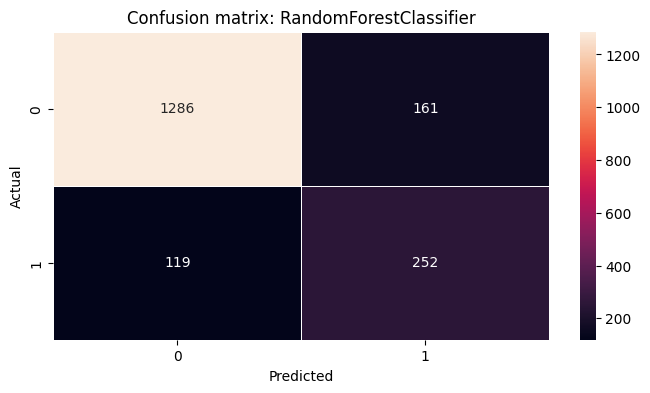

In [148]:
plt.figure(figsize=(8, 4))
sns.heatmap(confusion_matrix(target_valid, predictions), annot=True, fmt='g', linewidth=.5)
plt.title('Confusion matrix: RandomForestClassifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

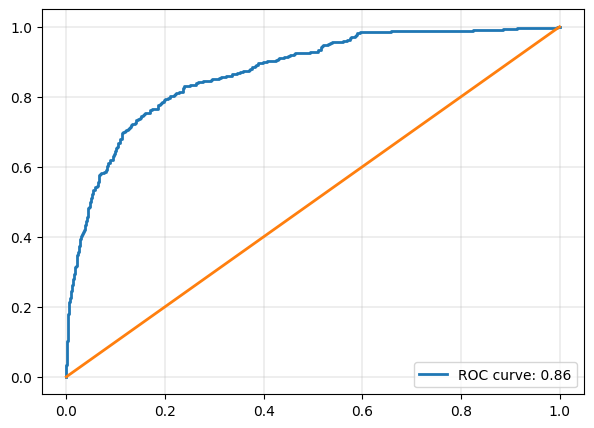

In [149]:
plt.figure(figsize=(7, 5))
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, label=f'ROC curve: {roc_auc_dtc:.2f}')
plt.plot([0, 1], [0, 1], lw=2, linestyle='-')
plt.legend(loc='lower right')
plt.grid(linewidth=0.3)

#### LogisticRegression (Логистическая регрессия)

In [150]:
%%time

best_model = None
best_model_iter = 0
best_result = 0
for iter in range(100, 10000, 100):
    model = LogisticRegression(random_state=RANDOM_STATE_, solver='lbfgs', max_iter=iter,
                              class_weight='balanced')
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    result = f1_score(target_valid, predictions)
    if result > best_result:
        best_model_lr_wc = model
        best_result = result
        best_model_iter = iter
print('Лучший результат F1 score:', best_result)
print('Гиперпараметры:', 'n_estimators:', best_model_iter)

Лучший результат F1 score: 0.5079365079365079
Гиперпараметры: n_estimators: 100
CPU times: user 3.05 s, sys: 2.17 s, total: 5.21 s
Wall time: 2.74 s


Обучим модель с подобранными гиперпараметрами и посмотрим метрики:

In [151]:
predictions = best_model_lr_wc.predict(features_valid)

accuracy_valid_lr = accuracy_score(predictions, target_valid)
precision_valid_lr = precision_score(target_valid, predictions)
recall_valid_lr = recall_score(target_valid, predictions)
f1_score_lr = f1_score(target_valid, predictions)

print('Accuracy score:', accuracy_valid_lr)
print('Precision score:', precision_valid_lr)
print('Recall score:', recall_valid_lr)
print('F1 score:', f1_score_lr)

Accuracy score: 0.7101210121012101
Precision score: 0.38857142857142857
Recall score: 0.7331536388140162
F1 score: 0.5079365079365079


In [152]:
probabilities_valid = best_model_lr_wc.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
roc_auc_lr = roc_auc_score(target_valid, probabilities_one_valid)
print('ROC-AUC логистической регрессии:', roc_auc_lr)

ROC-AUC логистической регрессии: 0.7907428139267598


Визуализируем матрицу ошибок

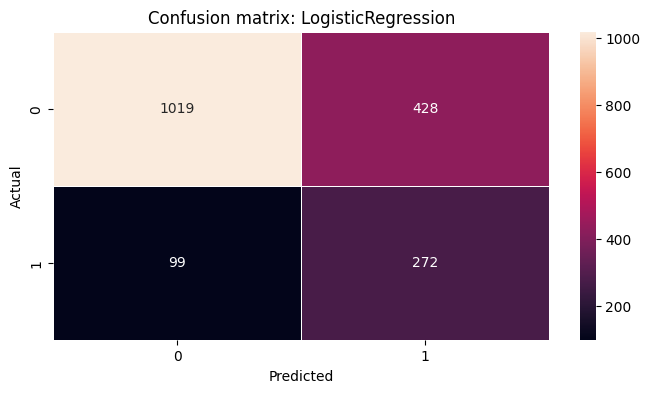

In [153]:
plt.figure(figsize=(8, 4))
sns.heatmap(confusion_matrix(target_valid, predictions), annot=True, fmt='g', linewidth=.5)
plt.title('Confusion matrix: LogisticRegression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

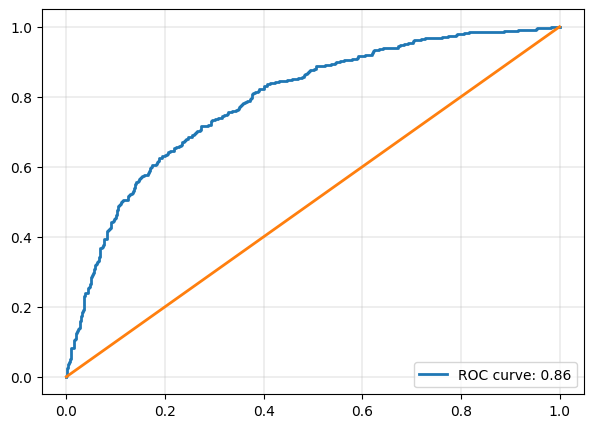

In [154]:
plt.figure(figsize=(7, 5))
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, label=f'ROC curve: {roc_auc_dtc:.2f}')
plt.plot([0, 1], [0, 1], lw=2, linestyle='-')
plt.legend(loc='lower right')
plt.grid(linewidth=0.3)

Соберем данные исследования в таблицу:

In [155]:
data = [{'Accuracy': accuracy_valid_dtc, 'Recall': recall_valid_dtc, 'Precision': precision_valid_dtc,
         'F1': f1_score_dtc, 'ROC-AUC': roc_auc_dtc},
                  {'Accuracy': accuracy_valid_rfc, 'Recall': recall_valid_rfc, 'Precision': precision_valid_rfc,
                   'F1': f1_score_rfc, 'ROC-AUC': roc_auc_rfc},
                  {'Accuracy': accuracy_valid_lr, 'Recall': recall_valid_lr, 'Precision': precision_valid_lr,
                   'F1': f1_score_lr, 'ROC-AUC': roc_auc_lr}]
model_result = pd.DataFrame(data, index=['DecisionTreeClassifier (Дерево решений)',
                                             'RandomForestClassifier (Случайный лес)',
                                             'LogisticRegression (Логистическая регрессия)'])
model_result

,Accuracy,Recall,Precision,F1,ROC-AUC
DecisionTreeClassifier (Дерево решений),0.792629,0.760108,0.494737,0.599362,0.855779
RandomForestClassifier (Случайный лес),0.845985,0.679245,0.610169,0.642857,0.872345
LogisticRegression (Логистическая регрессия),0.710121,0.733154,0.388571,0.507937,0.790743


#### Выводы:

Исследован первый метод борьбы с дисбалансом - взвешивание классов. Качество модели немного улучшилось. Лучшие метрики сохраняются у случайного леса. Метрика ROC-AUC во всех моделях выше метрики F1

### Увеличение выборки (upsampling)

Преобразование проходит в несколько этапов: <br>
Разделить обучающую выборку на отрицательные и положительные объекты; <br>
Скопировать несколько раз положительные объекты; <br>
С учётом полученных данных создать новую обучающую выборку; <br>
Перемешать данные: идущие друг за другом одинаковые вопросы не помогут обучению.

In [156]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=RANDOM_STATE_)

    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

In [157]:
target_upsampled.value_counts()

1    4448
0    4342
Name: exited, dtype: int64

#### DecisionTreeClassifier (Дерево решений)

In [158]:
%%time

best_model = None
best_model_depth = 0
best_model_leaf = 0
best_result = 0

for depth in range(1, 20):
    for i in range(1, 50):
            model = DecisionTreeClassifier(random_state=RANDOM_STATE_, max_depth=depth, min_samples_leaf=i)
            model.fit(features_upsampled, target_upsampled)
            predictions = model.predict(features_valid)
            result = f1_score(target_valid, predictions)
            if result > best_result:
                best_model_dtc_u = model
                best_model_depth = depth
                best_model_leaf = i
                best_result = result
print('Лучший результат F1 score:', best_result)
print('Гиперпараметры:', 'max_depth:', best_model_depth, ', min_samples_leaf:', best_model_leaf)

Лучший результат F1 score: 0.5973741794310722
Гиперпараметры: max_depth: 8 , min_samples_leaf: 48
CPU times: user 30.3 s, sys: 54.9 ms, total: 30.3 s
Wall time: 30.5 s


In [159]:
predictions = best_model_dtc_u.predict(features_valid)

accuracy_valid_dtc = accuracy_score(predictions, target_valid)
precision_valid_dtc = precision_score(target_valid, predictions)
recall_valid_dtc = recall_score(target_valid, predictions)
f1_score_dtc = f1_score(target_valid, predictions)

print('Accuracy score:', accuracy_valid_dtc)
print('Precision score:', precision_valid_dtc)
print('Recall score:', recall_valid_dtc)
print('F1 score:', f1_score_dtc)

Accuracy score: 0.7975797579757976
Precision score: 0.5027624309392266
Recall score: 0.7358490566037735
F1 score: 0.5973741794310722


In [160]:
probabilities_valid = best_model_dtc_u.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
roc_auc_dtc = roc_auc_score(target_valid, probabilities_one_valid)
print('ROC-AUC дерева решений:', roc_auc_dtc)

ROC-AUC дерева решений: 0.8496592075434444


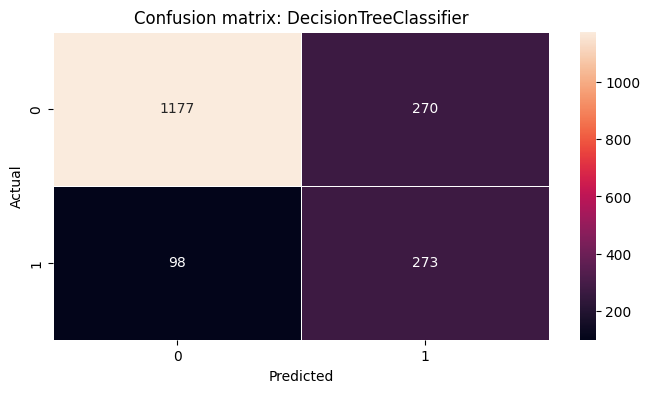

In [161]:
plt.figure(figsize=(8, 4))
sns.heatmap(confusion_matrix(target_valid, predictions), annot=True, fmt='g', linewidth=.5)
plt.title('Confusion matrix: DecisionTreeClassifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

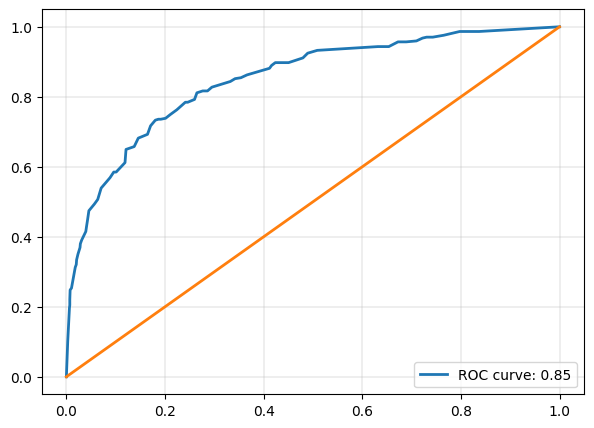

In [162]:
plt.figure(figsize=(7, 5))
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, label=f'ROC curve: {roc_auc_dtc:.2f}')
plt.plot([0, 1], [0, 1], lw=2, linestyle='-')
plt.legend(loc='lower right')
plt.grid(linewidth=0.3)

#### RandomForestClassifier (Случайный лес)

In [163]:
%%time

best_model = None
best_model_est = 0
best_model_depth = 0
best_result = 0
for est in range(10, 101, 10):
    for depth in range(1, 20):
        model = RandomForestClassifier(random_state=RANDOM_STATE_, n_estimators=est, max_depth=depth)
        model.fit(features_upsampled, target_upsampled)
        predictions = model.predict(features_valid)
        result = f1_score(target_valid, predictions)
        if result > best_result:
            best_model_rfc_u = model
            best_result = result
            best_model_est = est
            best_model_depth = depth
print('Лучший результат F1 score:', best_result)
print('Гиперпараметры:', 'n_estimators:', best_model_est, ', max_depth:', best_model_depth)

Лучший результат F1 score: 0.646074646074646
Гиперпараметры: n_estimators: 20 , max_depth: 12
CPU times: user 1min 39s, sys: 210 ms, total: 1min 40s
Wall time: 1min 40s


In [164]:
predictions = best_model_rfc_u.predict(features_valid)

accuracy_valid_rfc = accuracy_score(predictions, target_valid)
precision_valid_rfc = precision_score(target_valid, predictions)
recall_valid_rfc = recall_score(target_valid, predictions)
f1_score_rfc = f1_score(target_valid, predictions)

print('Accuracy score:', accuracy_valid_rfc)
print('Precision score:', precision_valid_rfc)
print('Recall score:', recall_valid_rfc)
print('F1 score:', f1_score_rfc)

Accuracy score: 0.8487348734873488
Precision score: 0.6182266009852216
Recall score: 0.6765498652291105
F1 score: 0.646074646074646


In [165]:
probabilities_valid = best_model_rfc_u.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
roc_auc_rfc = roc_auc_score(target_valid, probabilities_one_valid)
print('ROC-AUC случайного леса:', roc_auc_rfc)

ROC-AUC случайного леса: 0.8668152530470143


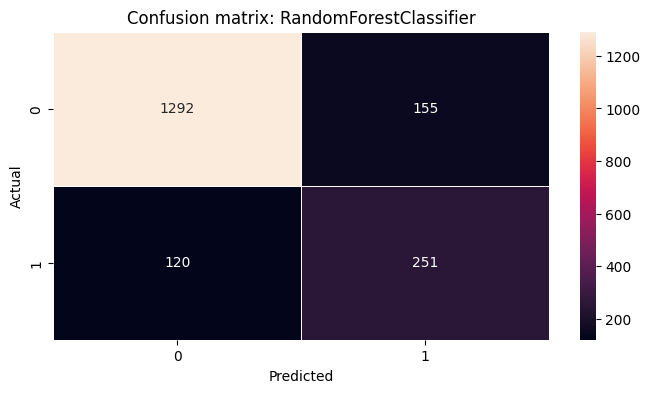

In [166]:
plt.figure(figsize=(8, 4))
sns.heatmap(confusion_matrix(target_valid, predictions), annot=True, fmt='g', linewidth=.5)
plt.title('Confusion matrix: RandomForestClassifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

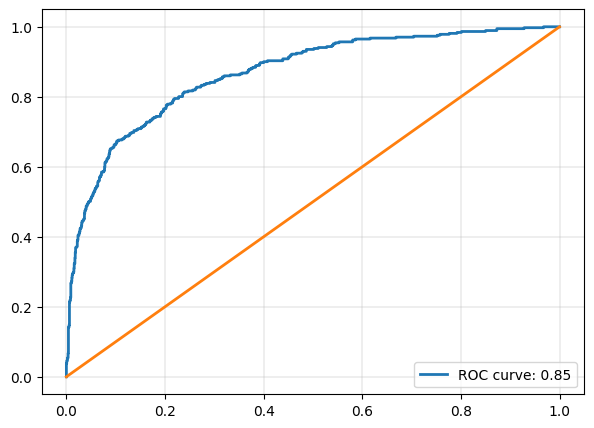

In [167]:
plt.figure(figsize=(7, 5))
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, label=f'ROC curve: {roc_auc_dtc:.2f}')
plt.plot([0, 1], [0, 1], lw=2, linestyle='-')
plt.legend(loc='lower right')
plt.grid(linewidth=0.3)

#### LogisticRegression (Логистическая регрессия)

In [168]:
%%time

best_model = None
best_model_iter = 0
best_result = 0
for iter in range(100, 10000, 100):
    model = LogisticRegression(random_state=RANDOM_STATE_, solver='lbfgs', max_iter=iter)
    model.fit(features_upsampled, target_upsampled)
    predictions = model.predict(features_valid)
    result = f1_score(target_valid, predictions)
    if result > best_result:
        best_model_lr_u = model
        best_result = result
        best_model_iter = iter
print('Лучший результат F1 score:', best_result)
print('Гиперпараметры:', 'n_estimators:', best_model_iter)

Лучший результат F1 score: 0.5050878815911193
Гиперпараметры: n_estimators: 100
CPU times: user 3.59 s, sys: 2.58 s, total: 6.17 s
Wall time: 3.53 s


In [169]:
predictions = best_model_lr_u.predict(features_valid)

accuracy_valid_lr = accuracy_score(predictions, target_valid)
precision_valid_lr = precision_score(target_valid, predictions)
recall_valid_lr = recall_score(target_valid, predictions)
f1_score_lr = f1_score(target_valid, predictions)

print('Accuracy score:', accuracy_valid_lr)
print('Precision score:', precision_valid_lr)
print('Recall score:', recall_valid_lr)
print('F1 score:', f1_score_lr)

Accuracy score: 0.7057205720572057
Precision score: 0.3845070422535211
Recall score: 0.7358490566037735
F1 score: 0.5050878815911193


In [170]:
probabilities_valid = best_model_lr_u.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
roc_auc_lr = roc_auc_score(target_valid, probabilities_one_valid)
print('ROC-AUC логистической регрессии:', roc_auc_lr)

ROC-AUC логистической регрессии: 0.7907446766895724


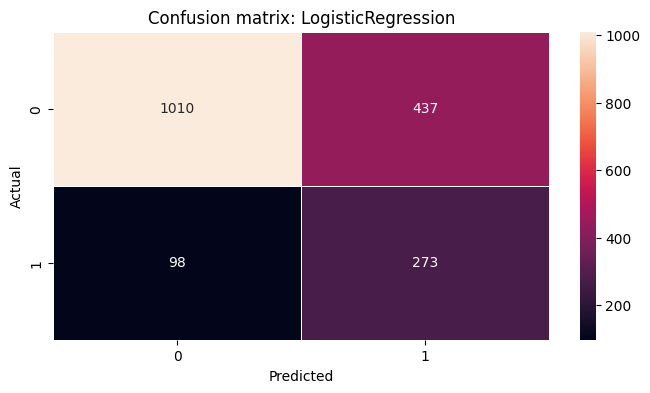

In [171]:
plt.figure(figsize=(8, 4))
sns.heatmap(confusion_matrix(target_valid, predictions), annot=True, fmt='g', linewidth=.5)
plt.title('Confusion matrix: LogisticRegression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

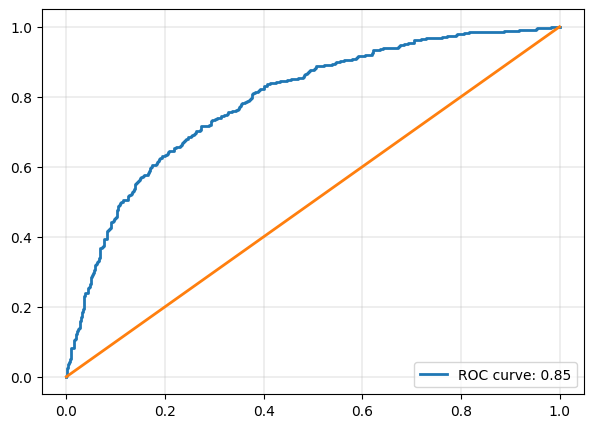

In [172]:
plt.figure(figsize=(7, 5))
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, label=f'ROC curve: {roc_auc_dtc:.2f}')
plt.plot([0, 1], [0, 1], lw=2, linestyle='-')
plt.legend(loc='lower right')
plt.grid(linewidth=0.3)

In [173]:
data = [{'Accuracy': accuracy_valid_dtc, 'Recall': recall_valid_dtc, 'Precision': precision_valid_dtc,
         'F1': f1_score_dtc, 'ROC-AUC': roc_auc_dtc},
                  {'Accuracy': accuracy_valid_rfc, 'Recall': recall_valid_rfc, 'Precision': precision_valid_rfc,
                   'F1': f1_score_rfc, 'ROC-AUC': roc_auc_rfc},
                  {'Accuracy': accuracy_valid_lr, 'Recall': recall_valid_lr, 'Precision': precision_valid_lr,
                   'F1': f1_score_lr, 'ROC-AUC': roc_auc_lr}]
model_result = pd.DataFrame(data, index=['DecisionTreeClassifier (Дерево решений)',
                                             'RandomForestClassifier (Случайный лес)',
                                             'LogisticRegression (Логистическая регрессия)'])
model_result

,Accuracy,Recall,Precision,F1,ROC-AUC
DecisionTreeClassifier (Дерево решений),0.797580,0.735849,0.502762,0.597374,0.849659
RandomForestClassifier (Случайный лес),0.848735,0.676550,0.618227,0.646075,0.866815
LogisticRegression (Логистическая регрессия),0.705721,0.735849,0.384507,0.505088,0.790745


#### Выводы:

Лучшие метрики также сохраняются у случайного леса

### Уменьшение выборки (downsampling)

Сделаем объекты частого класса не такими частыми - вместо повторения важных вопросов уберём часть неважных.

Преобразование проходит в несколько этапов:  <br>
Разделить обучающую выборку на отрицательные и положительные объекты; <br>
Случайным образом отбросить часть из отрицательных объектов; <br>
С учётом полученных данных создать новую обучающую выборку; <br>
Перемешать данные. Положительные не должны идти следом за отрицательными: алгоритмам будет сложнее обучаться.

fraction подберем вручную с учетом дисбаланса классов

In [174]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=RANDOM_STATE_)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=RANDOM_STATE_)] + [target_ones])

    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=RANDOM_STATE_)

    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.28)

model = LogisticRegression(random_state=RANDOM_STATE_, solver='liblinear')
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)

print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.5182266009852218


In [175]:
features_downsampled

,credit_score,age,tenure,balance,num_of_products,has_cr_card,is_active_member,estimated_salary,geography_Germany,geography_Spain,gender_Male
6281,2.081881,-0.756795,-0.357331,-1.222967,0.789359,0,0,0.915012,0.0,0.0,1.0
3284,1.706906,0.874386,1.382122,0.963629,-0.910943,1,1,1.497113,0.0,0.0,1.0
3845,0.644475,-0.468939,1.034232,0.603320,-0.910943,1,0,-0.119129,0.0,0.0,1.0
9572,-0.063812,-2.004168,0.686341,-1.222967,-0.910943,0,1,-0.695247,0.0,1.0,1.0
9766,1.561082,0.010820,-0.357331,0.301806,-0.910943,1,0,-1.490164,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
3109,2.081881,0.778434,1.730013,0.928167,-0.910943,0,0,-1.265855,1.0,0.0,0.0
2113,0.915291,-0.372988,0.338450,0.405730,-0.910943,0,0,-0.251372,1.0,0.0,1.0
8767,-1.022082,-0.948698,1.730013,-1.222967,0.789359,1,0,-1.520048,0.0,0.0,1.0
7453,1.331930,-0.372988,-1.401003,1.209528,2.489660,1,1,0.549003,1.0,0.0,0.0


In [176]:
target_downsampled.value_counts()

0    1216
1    1112
Name: exited, dtype: int64

#### DecisionTreeClassifier (Дерево решений)

In [177]:
%%time

best_model = None
best_model_depth = 0
best_model_leaf = 0
best_result = 0

for depth in range(1, 20):
    for i in range(1, 50):
            model = DecisionTreeClassifier(random_state=RANDOM_STATE_, max_depth=depth, min_samples_leaf=i)
            model.fit(features_downsampled, target_downsampled)
            predictions = model.predict(features_valid)
            result = f1_score(target_valid, predictions)
            if result > best_result:
                best_model_dtc_d = model
                best_model_depth = depth
                best_model_leaf = i
                best_result = result
print('Лучший результат F1 score:', best_result)
print('Гиперпараметры:', 'max_depth:', best_model_depth, ', min_samples_leaf:', best_model_leaf)

Лучший результат F1 score: 0.5977528089887639
Гиперпараметры: max_depth: 5 , min_samples_leaf: 2
CPU times: user 12.3 s, sys: 45.5 ms, total: 12.3 s
Wall time: 12.4 s


In [178]:
predictions = best_model_dtc_d.predict(features_valid)

accuracy_valid_dtc = accuracy_score(predictions, target_valid)
precision_valid_dtc = precision_score(target_valid, predictions)
recall_valid_dtc = recall_score(target_valid, predictions)
f1_score_dtc = f1_score(target_valid, predictions)

print('Accuracy score:', accuracy_valid_dtc)
print('Precision score:', precision_valid_dtc)
print('Recall score:', recall_valid_dtc)
print('F1 score:', f1_score_dtc)

Accuracy score: 0.8030803080308031
Precision score: 0.51252408477842
Recall score: 0.7169811320754716
F1 score: 0.5977528089887639


In [179]:
probabilities_valid = best_model_dtc_d.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
roc_auc_dtc = roc_auc_score(target_valid, probabilities_one_valid)
print('ROC-AUC дерева решений:', roc_auc_dtc)

ROC-AUC дерева решений: 0.847338205079009


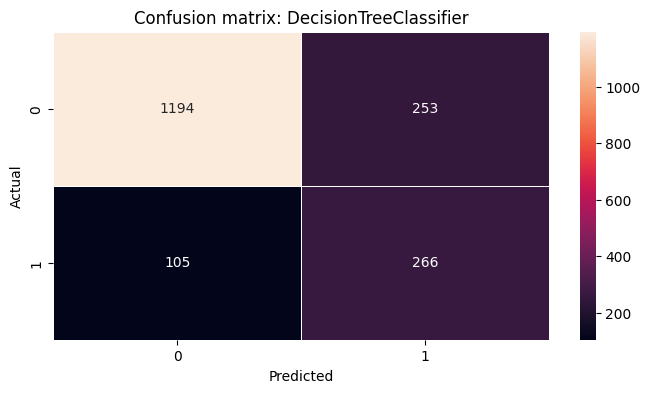

In [180]:
plt.figure(figsize=(8, 4))
sns.heatmap(confusion_matrix(target_valid, predictions), annot=True, fmt='g', linewidth=.5)
plt.title('Confusion matrix: DecisionTreeClassifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

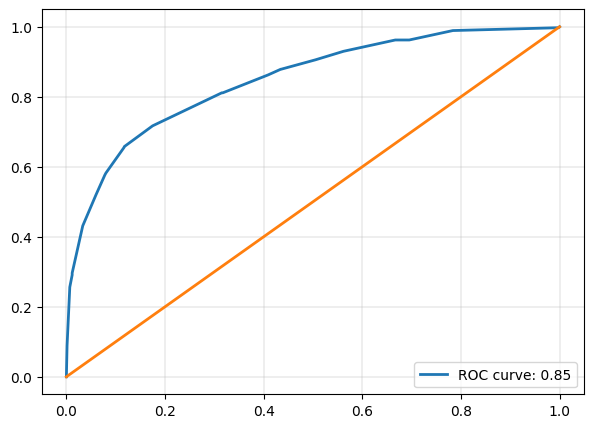

In [181]:
plt.figure(figsize=(7, 5))
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, label=f'ROC curve: {roc_auc_dtc:.2f}')
plt.plot([0, 1], [0, 1], lw=2, linestyle='-')
plt.legend(loc='lower right')
plt.grid(linewidth=0.3)

#### RandomForestClassifier (Случайный лес)

In [182]:
%%time

best_model = None
best_model_est = 0
best_model_depth = 0
best_result = 0
for est in range(10, 101, 10):
    for depth in range(1, 20):
        model = RandomForestClassifier(random_state=RANDOM_STATE_, n_estimators=est, max_depth=depth)
        model.fit(features_downsampled, target_downsampled)
        predictions = model.predict(features_valid)
        result = f1_score(target_valid, predictions)
        if result > best_result:
            best_model_rfc_d = model
            best_result = result
            best_model_est = est
            best_model_depth = depth
print('Лучший результат F1 score:', best_result)
print('Гиперпараметры:', 'n_estimators:', best_model_est, ', max_depth:', best_model_depth)

Лучший результат F1 score: 0.6329386437029063
Гиперпараметры: n_estimators: 90 , max_depth: 12
CPU times: user 44.7 s, sys: 145 ms, total: 44.9 s
Wall time: 45.2 s


In [183]:
predictions = best_model_rfc_d.predict(features_valid)

accuracy_valid_rfc = accuracy_score(predictions, target_valid)
precision_valid_rfc = precision_score(target_valid, predictions)
recall_valid_rfc = recall_score(target_valid, predictions)
f1_score_rfc = f1_score(target_valid, predictions)

print('Accuracy score:', accuracy_valid_rfc)
print('Precision score:', precision_valid_rfc)
print('Recall score:', recall_valid_rfc)
print('F1 score:', f1_score_rfc)

Accuracy score: 0.8124312431243125
Precision score: 0.5268817204301075
Recall score: 0.7924528301886793
F1 score: 0.6329386437029063


In [184]:
probabilities_valid = best_model_rfc_d.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
roc_auc_rfc = roc_auc_score(target_valid, probabilities_one_valid)
print('ROC-AUC случайного леса:', roc_auc_rfc)

ROC-AUC случайного леса: 0.8782665874371552


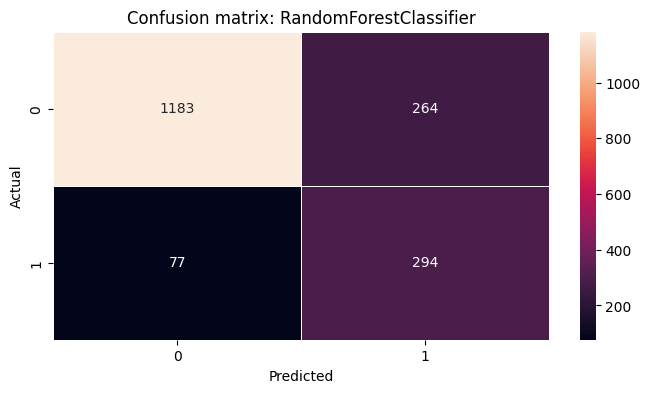

In [185]:
plt.figure(figsize=(8, 4))
sns.heatmap(confusion_matrix(target_valid, predictions), annot=True, fmt='g', linewidth=.5)
plt.title('Confusion matrix: RandomForestClassifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

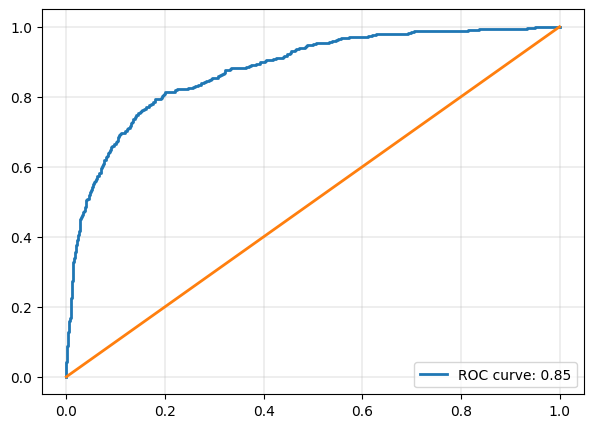

In [186]:
plt.figure(figsize=(7, 5))
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, label=f'ROC curve: {roc_auc_dtc:.2f}')
plt.plot([0, 1], [0, 1], lw=2, linestyle='-')
plt.legend(loc='lower right')
plt.grid(linewidth=0.3)

#### LogisticRegression (Логистическая регрессия)

In [187]:
%%time

best_model = None
best_model_iter = 0
best_result = 0
for iter in range(100, 10000, 100):
    model = LogisticRegression(random_state=RANDOM_STATE_, solver='lbfgs', max_iter=iter)
    model.fit(features_downsampled, target_downsampled)
    predictions = model.predict(features_valid)
    result = f1_score(target_valid, predictions)
    if result > best_result:
        best_model_lr_d = model
        best_result = result
        best_model_iter = iter
print('Лучший результат F1 score:', best_result)
print('Гиперпараметры:', 'n_estimators:', best_model_iter)

Лучший результат F1 score: 0.5182266009852218
Гиперпараметры: n_estimators: 100
CPU times: user 2.17 s, sys: 1.69 s, total: 3.86 s
Wall time: 2.3 s


In [188]:
predictions = best_model_lr_d.predict(features_valid)

accuracy_valid_lr = accuracy_score(predictions, target_valid)
precision_valid_lr = precision_score(target_valid, predictions)
recall_valid_lr = recall_score(target_valid, predictions)
f1_score_lr = f1_score(target_valid, predictions)

print('Accuracy score:', accuracy_valid_lr)
print('Precision score:', precision_valid_lr)
print('Recall score:', recall_valid_lr)
print('F1 score:', f1_score_lr)

Accuracy score: 0.731023102310231
Precision score: 0.4083850931677019
Recall score: 0.7088948787061995
F1 score: 0.5182266009852218


In [189]:
probabilities_valid = best_model_lr_d.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
roc_auc_lr = roc_auc_score(target_valid, probabilities_one_valid)
print('ROC-AUC логистической регрессии:', roc_auc_lr)

ROC-AUC логистической регрессии: 0.7909626199386406


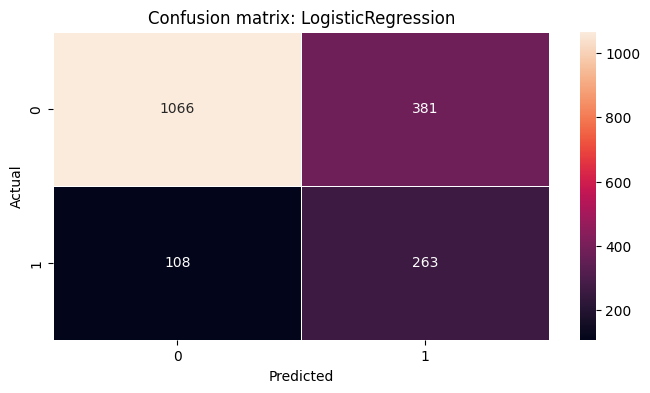

In [190]:
plt.figure(figsize=(8, 4))
sns.heatmap(confusion_matrix(target_valid, predictions), annot=True, fmt='g', linewidth=.5)
plt.title('Confusion matrix: LogisticRegression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

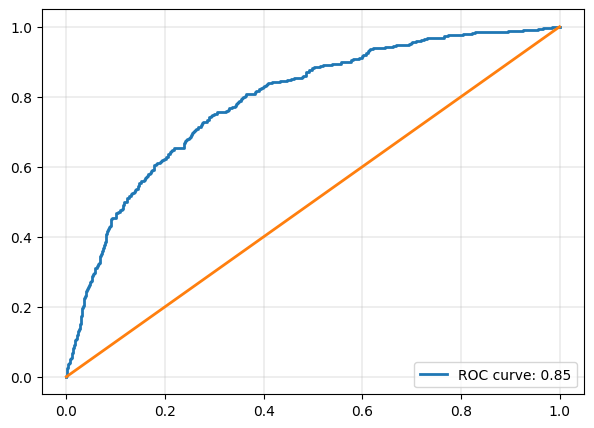

In [191]:
plt.figure(figsize=(7, 5))
fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, label=f'ROC curve: {roc_auc_dtc:.2f}')
plt.plot([0, 1], [0, 1], lw=2, linestyle='-')
plt.legend(loc='lower right')
plt.grid(linewidth=0.3)

In [192]:
data = [{'Accuracy': accuracy_valid_dtc, 'Recall': recall_valid_dtc, 'Precision': precision_valid_dtc,
         'F1': f1_score_dtc, 'ROC-AUC': roc_auc_dtc},
                  {'Accuracy': accuracy_valid_rfc, 'Recall': recall_valid_rfc, 'Precision': precision_valid_rfc,
                   'F1': f1_score_rfc, 'ROC-AUC': roc_auc_rfc},
                  {'Accuracy': accuracy_valid_lr, 'Recall': recall_valid_lr, 'Precision': precision_valid_lr,
                   'F1': f1_score_lr, 'ROC-AUC': roc_auc_lr}]
model_result = pd.DataFrame(data, index=['DecisionTreeClassifier (Дерево решений)',
                                             'RandomForestClassifier (Случайный лес)',
                                             'LogisticRegression (Логистическая регрессия)'])
model_result

,Accuracy,Recall,Precision,F1,ROC-AUC
DecisionTreeClassifier (Дерево решений),0.803080,0.716981,0.512524,0.597753,0.847338
RandomForestClassifier (Случайный лес),0.812431,0.792453,0.526882,0.632939,0.878267
LogisticRegression (Логистическая регрессия),0.731023,0.708895,0.408385,0.518227,0.790963


#### Выводы:

Лучшие метрики также сохраняются у случайного леса. В целом уменьшение выборки (downsampling) сработало лучше увеличения (upsampling)

### Выводы по методам борьбы с дисбалансом:
- Взвешивание классов, увеличение и уменьшение выборки улучшает модель по сравнению исходной.
- Самый высокий результат даёт уменьшение выборки (downsampling).
- ROC-AUC колеблется от 79% до 87%
- По результам всех исследований, самые высокие метрики F1 и ROC-AUC у модели, обученной с помощью случайного леса с взвешиванием классов. На ней и будем проводить тестирование.

## Тестирование модели

Для повышения качества модели объединим валидационную и обучающую выборки. За модель берем случайный лес с взвешиванием классов

In [193]:
features_train_final = pd.concat([features_train, features_valid], axis=0, ignore_index=True)
target_train_final = pd.concat([target_train, target_valid], axis=0, ignore_index=True)

Протестируем модель на объединенной выборке

In [194]:
best_model_rfc_wc.fit(features_train_final, target_train_final)

predictions = best_model_rfc_wc.predict(features_test)

accuracy_valid_dtc = accuracy_score(predictions, target_test)
precision_valid_dtc = precision_score(target_test, predictions)
recall_valid_dtc = recall_score(target_test, predictions)
f1_score_dtc = f1_score(target_test, predictions)

print('Accuracy score:', accuracy_valid_dtc)
print('Precision score:', precision_valid_dtc)
print('Recall score:', recall_valid_dtc)
print('F1 score:', f1_score_dtc)

Accuracy score: 0.8240791643760308
Precision score: 0.5632754342431762
Recall score: 0.6118598382749326
F1 score: 0.58656330749354


In [195]:
probabilities_valid = best_model_rfc_wc.predict_proba(features_test)
probabilities_one_valid = probabilities_valid[:, 1]
roc_auc_rfc = roc_auc_score(target_test, probabilities_one_valid)
print('ROC-AUC случайного леса:', roc_auc_rfc)

ROC-AUC случайного леса: 0.8516812854611249


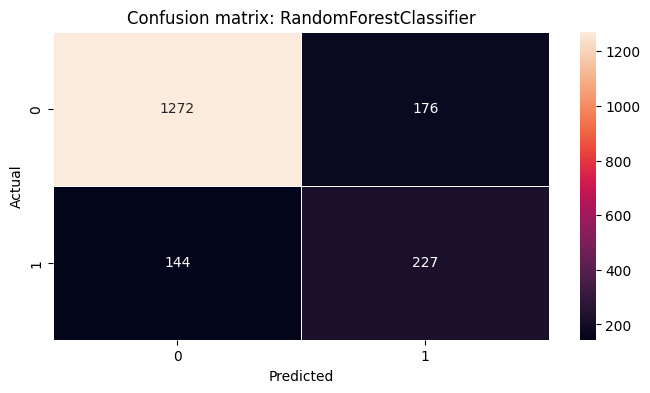

In [196]:
plt.figure(figsize=(8, 4))
sns.heatmap(confusion_matrix(target_test, predictions), annot=True, fmt='g', linewidth=.5)
plt.title('Confusion matrix: RandomForestClassifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

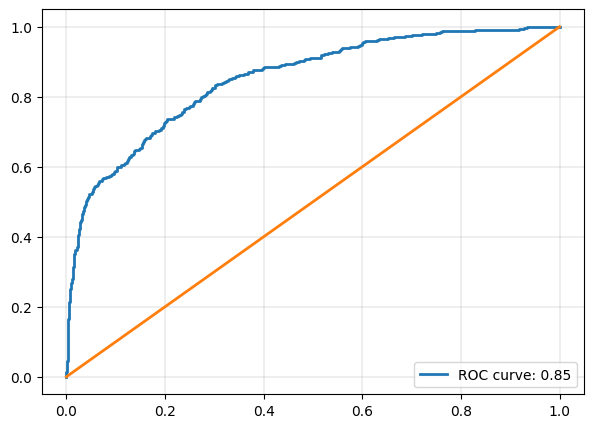

In [197]:
plt.figure(figsize=(7, 5))
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_valid)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=2, label=f'ROC curve: {roc_auc_dtc:.2f}')
plt.plot([0, 1], [0, 1], lw=2, linestyle='-')
plt.legend(loc='lower right')
plt.grid(linewidth=0.3)

Удалось достигнуть значения F1-меры для тестовой выборки выше необходимого по условию уровня: 0.59

## Общие выводы по исследованию:

- Загрузили датафрейм и исследовали его
- Удалили нецелевые для исследования признаки (row_number, customer_id и surname)
- Избавились от пропусков в параметре Tenure
- С помощью ОНЕ перекодировали признаки geography и gender в числовые
- Масштабировали числовые признаки credit_score, age, balance, estimated_salary
- Обнаружили в  целевом признаке exited достаточно сильный дисбаланс классов - только 20% отражают факт ухода клиента


- Исследовали модели без учета дисбаланса и обнаружили, что случайный лес по метрике F1-мера показывает лучший результат. Матрицы ошибок указывают на сильный дисбаланс классов.  
- Исследовали модели с учетом дисбаланса с использованием взвешивания классов, с использованием увеличенной выборки(Upsampling), с использованием уменьшенной выборки(Downsampling): обнаружили, что везде случайный лес в F1-мере показывает лучший результат.
- Взвешивание классов дает самый высокий результат.
- По результам всех исследований самые высокие метрики F1 и ROC-AUC у модели, обученной с помощью случайного леса с взвешиванием классов.
- Провели тестирование наиболее успешной модели:
    - Получили значения метрик:
        - Accuracy score: 0.8240791643760308
        - Precision score: 0.5632754342431762
        - Recall score: 0.6118598382749326
        - F1 score: 0.58656330749354
        - ROC-AUC случайного леса: 0.8516812854611249
- Удалось достичь значения F1-меры не менее 0.59
